The dataset represents data from people of a wide range of ages from 3 locations in 8 counties in England and the bounce rates of those people in a specific website.

A bounce rate is a measure of how quickly someone leave a website, e.g. the number of seconds after which a user leaves a certain webpage in a website. Most websites want people to stay on their website for a long time as they are more likely to read another article, buy one of their products, click on some of the sponsored links etc. As such, it can be useful to understand why some users leave the website quicker than others.

The question that's being investigated is , if younger people are more likely to leave the website quicker.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('wbr.csv')
data.head()

,bounce_time,age,county,location
0,165.548520,16,devon,a
1,167.559314,34,devon,a
2,165.882952,6,devon,a
3,167.685525,19,devon,a
4,169.959681,34,devon,a


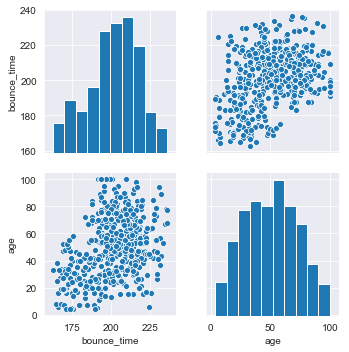

In [3]:
# Quick visualization of the dataset

sns.pairplot(data)

From this simple visualization there seems to be an increasing linear trend with respect to the bounce_time as the age factor increases.


,Method,RMSE
0,Linear regression,14.928334


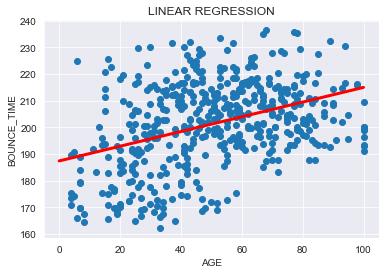

In [4]:
# 1.SIMPLE LINEAR REGRESSION

x= data.age[:,np.newaxis]
y=data.bounce_time

SLM = LinearRegression()

SLM.fit(x,y)

xfit= np.linspace(0,100,1000)
yfit= SLM.predict(xfit[:,np.newaxis])

plt.scatter(x,y)
plt.plot(xfit,yfit,LW=3,c='r')
plt.xlabel('AGE')
plt.ylabel('BOUNCE_TIME')
plt.title('LINEAR REGRESSION')


from sklearn import metrics

y_predict = SLM.predict(x) 
RMSE1 = (np.sqrt(metrics.mean_squared_error(y,y_predict)))

results = pd.DataFrame()
results['Method'] = ['Linear regression']
results['RMSE'] = RMSE1
results

So from this, it's quite evident that as age increases so does the bounce time. 

However, It's better to know whether certain assumptions such as homoscedastic ,independance between variables are met.

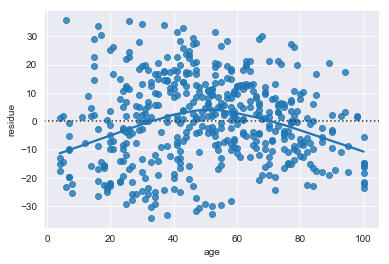

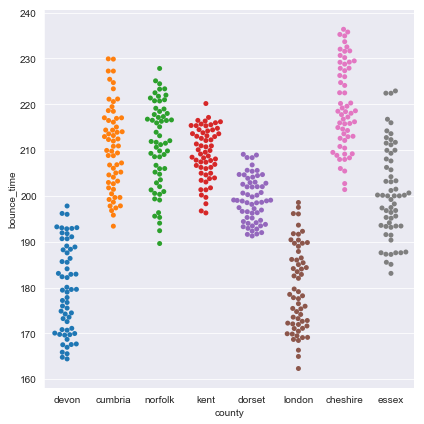

In [5]:
SLM_resid = pd.DataFrame()
SLM_resid['residue'] = y- y_predict
SLM_resid['age'] = data.age

sns.residplot(x='age', y='residue', data=SLM_resid , lowess=True)

sns.catplot(x='county' , y='bounce_time' , data=data , kind='swarm' , size=6)

From the looks of this, it's evident that there seems to be some heteroscedaticity in the residual distribution & definitely some substantial grouping among variables, So the data is not independent, and thus it is inappropriate to use a linear model for this data.

Well, maybe separate regressions for each the counties could help.

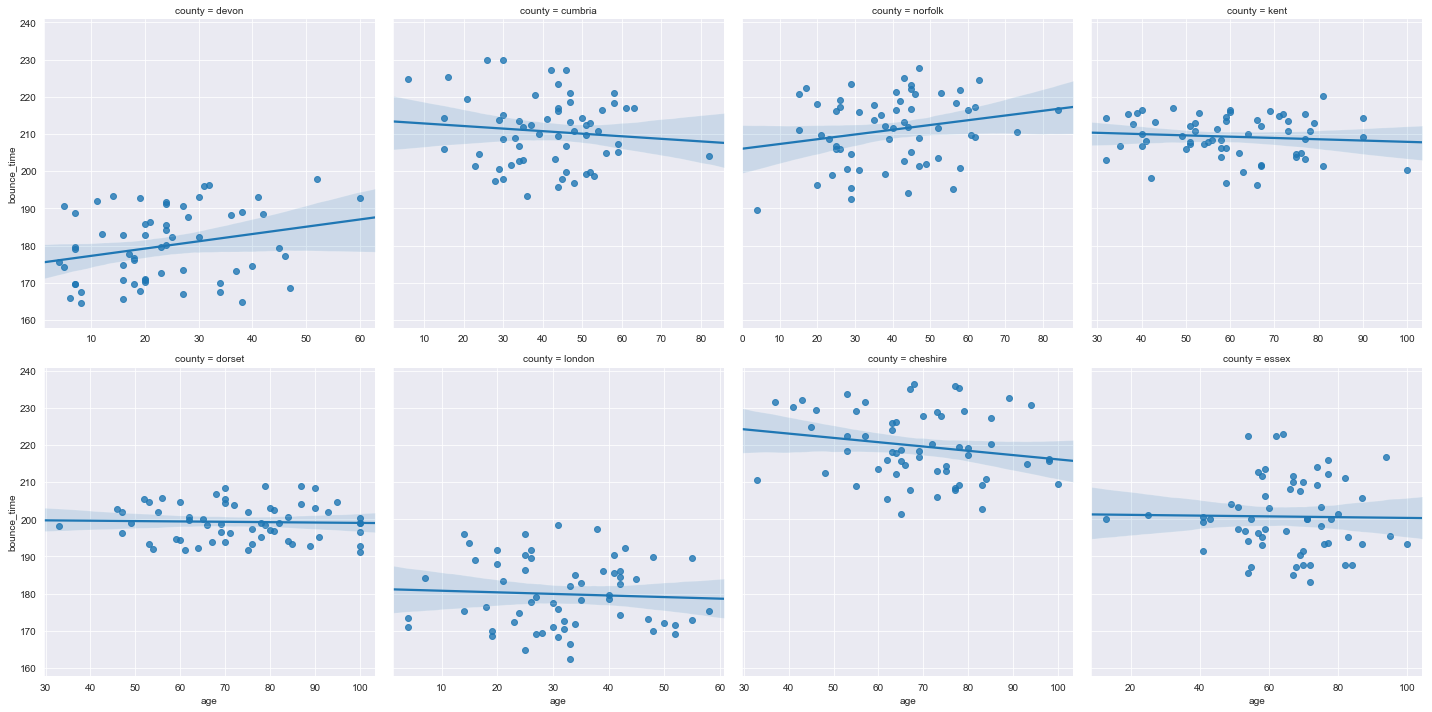

In [6]:
# 2.SEPERATE LINEAR REGRESSION

sns.lmplot(x='age' , y='bounce_time' , col='county' , data=data , col_wrap=4 , sharex=False)

In [7]:
sep_LM = LinearRegression()

counties= data.county.unique()

mse = np.empty(counties.size)

for i in range(counties.size):
    
    county = counties[i]
    
    x1 = data.age[data.county == county][:,np.newaxis]
    y1 = data.bounce_time[data.county == county]
    
    fit = SLM.fit(x1, y1)
    
    predict = SLM.predict(x1)
    mse[i] = (metrics.mean_squared_error(y1, predict))
RMSE1 = np.sqrt(mse.sum())

results.loc[1] = ['Seperate regression',RMSE1]
results

,Method,RMSE
0,Linear regression,14.928334
1,Seperate regression,23.914853


Now there are 8 different analyses, but the sample size has become very small, and the analysis is going in the other direction i.e., it was earlier considered that all counties were identical, whereas here the impact of age on bounce_time share no similarities between counties.

In addition, it's possible that the locations are dependant variables as well. It's better to check that out too.

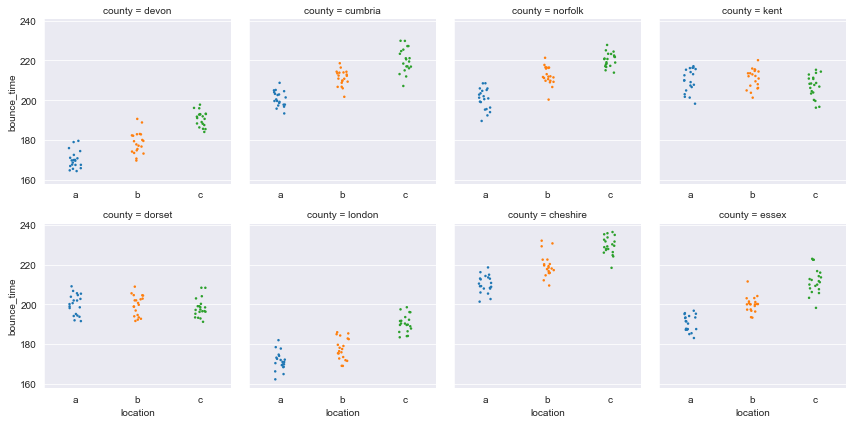

In [8]:
sns.catplot(x='location' , y='bounce_time' , col='county' , data=data , col_wrap=4 , sharex=False , height=3 , marker='.')

There's grouping here as well,but carrying on with indiviual regression for indiviual locations will greatly reduce the size of the sample, inturn decreasing the statistical power, and thus increasing the chances of a Type 1
Error by carrying out multiple comparisons.

To avoid this, the model could be modified to account for the different counties in a single linear model.

In [9]:
# 3.FIXED EFFECT 

new_data = pd.DataFrame(pd.concat([data,pd.get_dummies(data.county)],axis=1))

new_data.head()

,bounce_time,age,county,location,cheshire,cumbria,devon,dorset,essex,kent,london,norfolk
0,165.548520,16,devon,a,0,0,1,0,0,0,0,0
1,167.559314,34,devon,a,0,0,1,0,0,0,0,0
2,165.882952,6,devon,a,0,0,1,0,0,0,0,0
3,167.685525,19,devon,a,0,0,1,0,0,0,0,0
4,169.959681,34,devon,a,0,0,1,0,0,0,0,0


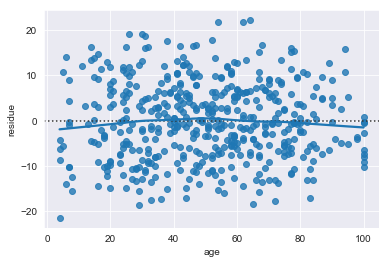

In [20]:
x3 = new_data.loc[:,np.concatenate((['age'],counties))] 

FELM = LinearRegression()
FELM.fit(x3,y)

FELM_resid = pd.DataFrame()
FELM_resid['residue'] = data.bounce_time - FELM.predict(x3)
FELM_resid['age'] = data.age

sns.residplot(x='age', y='residue' , data=FELM_resid , lowess=True)

The residuals are much better than before, being more evenly distributed with respect to age, and if we look at the predictions with each county:

,Method,RMSE
0,Linear regression,14.928334
1,Seperate regression,23.914853
2,Fixed,8.563396


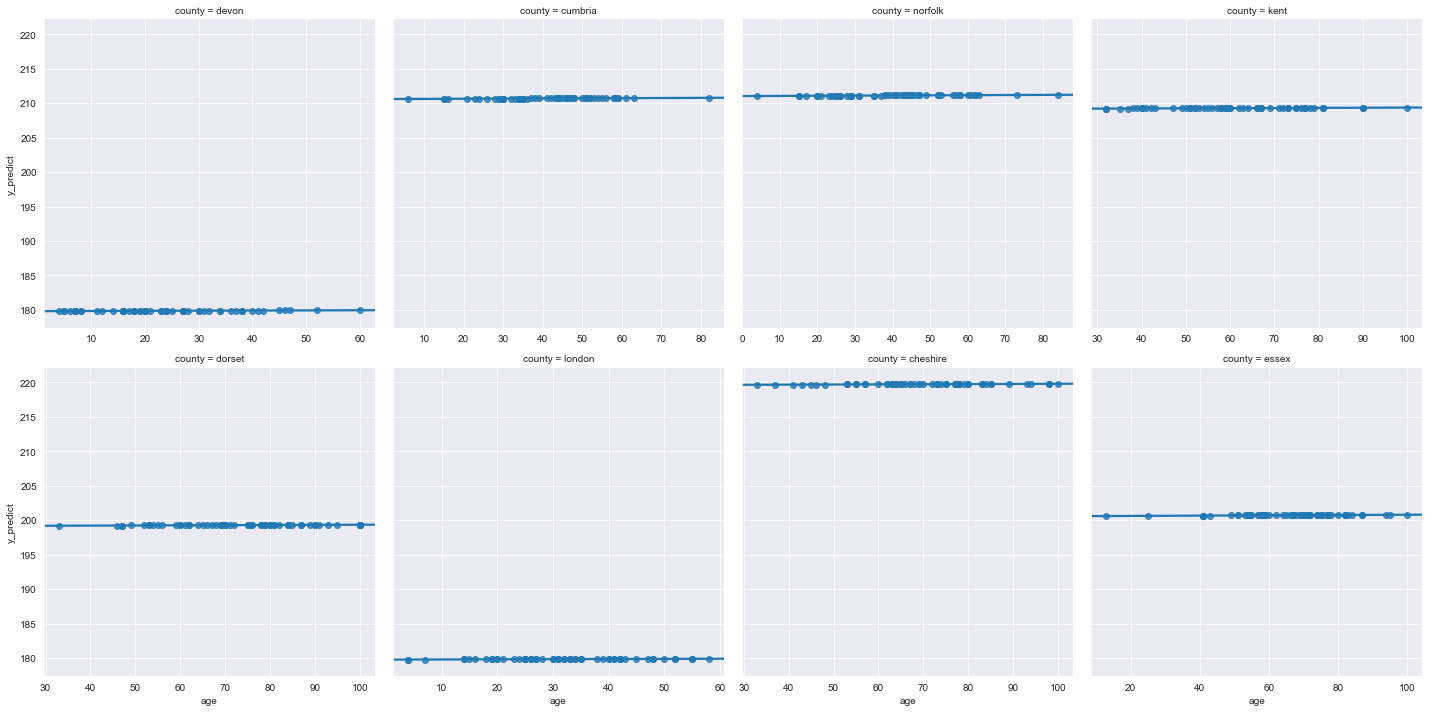

In [11]:
new_data['y_predict']=FELM.predict(x3)

sns.lmplot(x='age' , y='y_predict' , col='county' , data=new_data , sharex=False , col_wrap=4)

RMSE3 = np.sqrt(metrics.mean_squared_error(y,FELM.predict(x3)))
results.loc[2]=['Fixed',RMSE3]
results

Now the coefficient for the gradient given to age is substnantially smaller, and is likely that it's no longer significant. The following is the table of the coefficients:

In [12]:
FELM_coef = pd.DataFrame(zip(np.concatenate((['age'],counties)),FELM.coef_),columns=['Feature','coef'])

FELM_coef


,Feature,coef
0,age,0.002140
1,devon,-21.381957
2,cumbria,9.391460
3,norfolk,9.824419
4,kent,7.938668
5,dorset,-2.079637
6,london,-21.437323
7,cheshire,18.372916
8,essex,-0.628546


The model is estimating the difference in bounce times between the counties now as well, but it's not the matter of interest. And by including county in we are obscuring this. So to look at the impact of age on bounce times it's necessary to control for the variation between the different counties. So to do that, the counties should be treated as random effects.

In [13]:
# 4.MIXED EFFECTS

import statsmodels.formula.api as smf

MLM = smf.mixedlm('bounce_time ~ age', data=data , groups=data['county'])

MLMf = MLM.fit()

MLMf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: bounce_time
No. Observations: 480     Method:             REML       
No. Groups:       8       Scale:              74.7350    
Min. group size:  60      Likelihood:         -1736.1660 
Max. group size:  60      Converged:          Yes        
Mean group size:  60.0                                   
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   201.016    5.350 37.574 0.000 190.531 211.502
age           0.006    0.027  0.221 0.825  -0.047   0.059
Group Var   212.999   13.382                             
=========================================================

"""

In this summary of the model, it's clear that the age is having a more noticable impact than in the fixed modelearlier, however, importantly it is still not significantly different to 0, with the 95% interval for this coefficient spanning between -0.047 and 0.059

,Method,RMSE
0,Linear regression,14.928334
1,Seperate regression,23.914853
2,Fixed,8.563396
3,Mixed,8.563948


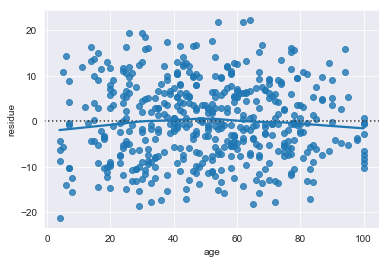

In [14]:
MLM_resid = pd.DataFrame()
MLM_resid['residue'] = MLMf.resid
MLM_resid['age'] = data.age

sns.residplot(x='age' , y='residue' , data=MLM_resid , lowess=True)

RMSE4 = np.sqrt(metrics.mean_squared_error(y,MLMf.fittedvalues))

results.loc[3] = ['Mixed',RMSE4]    
results

The residual plots of the Fixed and mixed effects regression look almost similar because the county has a random intercept, but the same slope. This is very similar to the fixed effect approach, where county was included as a term that would impact
the intercept. 

So the counties should also have random slops to have a differnet effect.

In [15]:
# 5.MIXED EFFECTS WITH RANDOM SLOPES

MRSLM = smf.mixedlm('bounce_time ~ age',data, groups=data['county'], re_formula='~age')
MRSLMf = MRSLM.fit()
MRSLMf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM  Dependent Variable:  bounce_time
No. Observations:   480      Method:              REML       
No. Groups:         8        Scale:               73.0644    
Min. group size:    60       Likelihood:          -1753.4285 
Max. group size:    60       Converged:           No         
Mean group size:    60.0                                     
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       201.729    5.573 36.200 0.000 190.807 212.651
age               0.008    0.629  0.013 0.990  -1.225   1.241
Group Var       232.136   13.099                             
Group x age Cov  -1.130    2.746                             
age Var           3.161                                      
=============================================================

"""

,Method,RMSE
0,Linear regression,14.928334
1,Seperate regression,23.914853
2,Fixed,8.563396
3,Mixed,8.563948
4,Mixed with random slope,8.459315


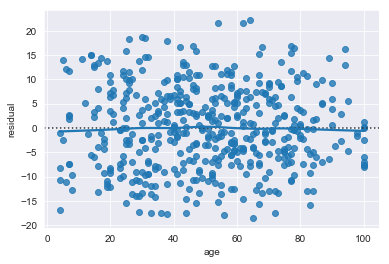

In [16]:
MRSLM_resid = pd.DataFrame()
MRSLM_resid['residual'] = MRSLMf.resid
MRSLM_resid['age'] = data.age

sns.residplot('age','residual',MRSLM_resid,lowess=True)

RMSE5 = np.sqrt(metrics.mean_squared_error(y,MRSLMf.fittedvalues))
results.loc[4] = ['Mixed with random slope', RMSE5]
results

The mixed model with random slopes is now performing much better, with our residuals ditributed more evenly. Crucially though,we can see that age does not impact the bounce rate, after controlling for the random variation caused by the county, i.e. with a random slope and intercept.

The data tells that individuals in certain counties took longer on the website, and that they happened to also be old. However, to get to this distinction we had to first treat county as a random effect. 

Now to include location in the model as well.

In [17]:
# 6.NESTED MIXED

data['county_location'] = data['county'] + '_' + data['location']
data.head()

,bounce_time,age,county,location,county_location
0,165.548520,16,devon,a,devon_a
1,167.559314,34,devon,a,devon_a
2,165.882952,6,devon,a,devon_a
3,167.685525,19,devon,a,devon_a
4,169.959681,34,devon,a,devon_a


In [18]:
NMLM = smf.mixedlm('bounce_time ~ age' , data , groups = data['county_location'] , re_formula='age' )
NMLMf = NMLM.fit()
NMLMf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
            Mixed Linear Model Regression Results
=============================================================
Model:              MixedLM  Dependent Variable:  bounce_time
No. Observations:   480      Method:              REML       
No. Groups:         24       Scale:               23.0904    
Min. group size:    20       Likelihood:          -1576.5526 
Max. group size:    20       Converged:           No         
Mean group size:    20.0                                     
-------------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
-------------------------------------------------------------
Intercept       200.821    3.572 56.215 0.000 193.819 207.823
age               0.008    0.418  0.019 0.985  -0.811   0.827
Group Var       288.169   20.943                             
Group x age Cov   0.617                                      
age Var           4.189                                      
=============================================================

"""

,Method,RMSE
0,Linear regression,14.928334
1,Seperate regression,23.914853
2,Fixed,8.563396
3,Mixed,8.563948
4,Mixed with random slope,8.459315
5,Nested Mixed,4.695709


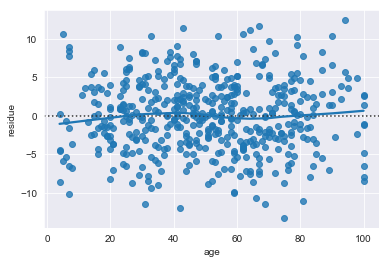

In [19]:
NMLM_resid = pd.DataFrame()
NMLM_resid['residue'] = NMLMf.resid
NMLM_resid['age'] = data.age

sns.residplot('age','residue',NMLM_resid,lowess=True)

RMSE6 = np.sqrt(metrics.mean_squared_error(y,NMLMf.fittedvalues))
results.loc[5] = ['Nested Mixed' , RMSE6]
results

The model has now amplified on the pior result, that age doesn't impact the bounce time but people in different locations spend more time on the webpage and they happen to be older.